# Script to plot synergy.

Adapted from previous scripts and formatted to correspond to '211014_synergies_per_species_richness_mean_auc_ok.py' by Pablo Guridi Fernandez

In [ ]:
#Just some comments about this script
#AUC:For the ancestral difference that we plot (violin plot) we don´t subtract initial population for community nor sum(monoculture). Careful in that script there are some data structures (ancestral_auc_mc) where I think I wrongly subtracted in_pop for sum(monoculture) and they are not even properly populated because seeds are renamed causing a problem, but ancestral_auc_mc is not used for the plot, so it´s fine.
#we do subtract initial_population*time steps for evolved condition; since then we take difference evolved- sum(monoculture) and we subtract in both of them, the difference remains the same, so although it is not super clean in the script I think we are fine 
#The plot we use I think that plots the average value per repeat (and for the number of tubes - x axes- we do the average of the number of species per tube in the repeat and then round to have an exact number). 

In [1]:
import os 
import sys
import copy
import scipy
import pickle
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.spatial.distance as dis

from os import listdir
from ast import literal_eval
from pathlib import Path
from math import sqrt,exp,log
from collections import Counter
from scipy.stats import shapiro
from scipy.stats import wilcoxon
from itertools import zip_longest
from os.path import isfile, isdir, join
from datetime import date, datetime


In [2]:
#where to find the data
# path = "/Users/pablo/Desktop/data_mitri/210822_2_ok/"
path = "/Users/pablo/Desktop/code_paper/data/210822/"  
path_ancestral_combs = "/Users/pablo/Desktop/code_paper/data/211005_all_communities/"
path_evolved_monocultures = "/Users/pablo/Desktop/code_paper/data/211004_old_monocultures/"


#some info about these results
#All the propagations we are using disassembly (d), propagule(p), migrant_pool(m), no_select(n),
#either under selection (s) or random (r) treatment
conditions = ["d2_s", "d3_s" "p_s", "m_s","n_r", "d2_r", "d3_r" "p_r", "m_r", "pip_s", "pip_r", "mip_s", "mip_r"]
#to rename for the plot, important in the same order as above
conditions_rename = ["D2S", "D3S", "PS", "MS","NR", "D2R", "D3R", "PR",  "MR", "PIS", "PIR", "MIS", "MIR"]
seeds = ["22", "23", "24", "25", "26"] #for the plot they will be renamed as 1-5
Nseeds = len(seeds)

rd = 49
tm = 80 #number of time steps in the simulation
rounds = 25
in_pop = 10 #initial population in monocultures used for the simulaitons
total_sp = 15
num_tubes = 21
num_repeats = 10

#where to store the results
#path_save = "/Users/pablo/Desktop/211111_results/"
path_save = "/Users/pablo/Desktop/220628_plots_mitri/"


In [3]:
#%%GENERATE DATA STRUCTURES TO ORGANISE THE INFORMATION
df_all_all = pd.DataFrame(columns=['com', "len_com", 'final_pop', 'max_pop', 'fold_change', 'auc', 'deg_score',
       'nut_score', 'sp_div_H', 'seed', "mc_deg_score", "mc_auc", "syn_auc","syn_deg"])

for i_s,seed in enumerate(seeds):
    df_all =  pd.read_csv(path_ancestral_combs +  seed + "/df.csv")
    df_all["seed"] = i_s+1 #add a column with the seed to the  dataframe (renamed as 1-5)

    # tuples are converted to string when we store as .csv , so we evaluate that. 
    df_all['com'] = df_all.com.apply(lambda x: literal_eval(str(x)))
    df_all["len_com"]=df_all.com.apply(len)
    df_mono = df_all[df_all['com'].map(len)<= 1]

    #append auc and deg synergy to each community
    mc_deg = []
    mc_auc = []
    c_num_sp = []
    for com in df_all["com"]:
        #calculate the corresponding degradation of the ancestral monocultures
        sum_deg = []
        sum_auc =[]
        for sp in com:
            deg = df_mono.loc[df_mono["com"]==(sp,),"deg_score"]
            auc = df_mono.loc[df_mono["com"]==(sp,),"auc"]
            sum_deg.append(float(deg))
            sum_auc.append(float(auc))
        mc_deg.append(sum(sum_deg))
        mc_auc.append(sum(sum_auc))
        #c_num_sp.append(colors[len(sum_deg)-1])
    
    df_all = df_all.assign(mc_deg_score = mc_deg)
    df_all = df_all.assign(mc_auc = mc_auc)

    #and also add colums direclty with the synergy
    df_all["syn_auc"] = df_all["auc"] - df_all["mc_auc"]
    df_all["syn_deg"] = df_all["deg_score"] - df_all["mc_deg_score"]
    
    #finally append to a dataframe wiht all the si
    df_all_all = df_all_all.append(df_all)

print(df_all_all)
#print(max_deg)
#print(mean_auc)
#print(mean_div)

                                                     com len_com    final_pop  \
0      (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...      15  1070.333333   
1         (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)      14  1045.333333   
2         (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14)      14   956.666667   
3         (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14)      14  1057.666667   
4         (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14)      14  1091.333333   
...                                                  ...     ...          ...   
32762                                              (10,)       1     1.333333   
32763                                              (11,)       1   555.333333   
32764                                              (12,)       1   210.000000   
32765                                              (13,)       1    80.000000   
32766                                              (14,)       1     1.000000   

          max_pop  fold_cha

In [4]:
com

(14,)

In [5]:
#%%Now we see the combinations we have at the end of each selecting method
#(reusing code)
#GENERATE DATA STRUCTURES
evolved_deg = {} #community
ancestral_deg_mc = {}
ancestral_deg_com = {}
evolved_auc = {}#community
ancestral_auc_mc = {}
ancestral_auc_com = {}
evolved_deg_mc = {}
evolved_auc_mc = {}

prop = 'd3_s'

len_com ={}
for i_s,seed in enumerate(seeds):
    evolved_deg[seed] = []
    ancestral_deg_mc[seed] = []
    ancestral_deg_com[seed] = []
    evolved_auc[seed] = []
    ancestral_auc_mc[seed] = []
    ancestral_auc_com[seed] = []
    evolved_deg_mc[seed] = []
    evolved_auc_mc[seed] = []    
    len_com[seed] = []

    for repeat in range(num_repeats):
        df_sp =  pd.read_csv(path + seed + "/" + prop + "/repeat" + str(repeat) + "/df_sp.csv")
        df_grid = pd.read_csv(path + seed + "/" + prop + "/repeat" + str(repeat) + "/df_grid.csv")
        df_sp = df_sp.loc[df_sp["round"] == rd]
        df_grid = df_grid.loc[df_grid["round"] == rd]
        #noe we will apend to the dict a list for each repeat
        evolved_deg_rep = []
        evolved_auc_rep = []
        ancestral_deg_mc_rep = []
        ancestral_auc_mc_rep = []
        ancestral_deg_com_rep = []
        ancestral_auc_com_rep = []
        evolved_deg_mc_rep = []
        evolved_auc_mc_rep = []
        len_com_rep =[]
            
        for tube in range(num_tubes):
            comb_tube = list(df_sp.loc[df_sp["tube"] == tube, "sp"])
                
            #PROBLEM I get sometimes(really rare), an empty "comb_tube" due to extinctions, so a quick solve just to see:
            if comb_tube:
                evolved_deg_rep.append(df_grid.loc[df_grid["tube"]==tube,"deg_score"].astype(float))
                evolved_auc_rep.append(np.subtract(df_grid.loc[df_grid["tube"]==tube,"tot_auc"].astype(float),
                                                   tm*df_grid.loc[df_grid["tube"]==tube,"tot_pop_0"].astype(float)))
                
                df_seed_and_comb = df_all_all.loc[(df_all_all["seed"]== (i_s + 1)) & (df_all_all["com"]==tuple(comb_tube)),:]
                ancestral_deg_mc_rep.append(df_seed_and_comb.loc[:,"mc_deg_score"].astype(float))
                ancestral_auc_mc_rep.append(np.subtract(df_seed_and_comb.loc[:,"mc_auc"].astype(float),
                                                        tm*in_pop)) #*len(comb_tube)?
                ancestral_deg_com_rep.append(df_all_all.loc[:,"deg_score"].astype(float))
                ancestral_auc_com_rep.append(np.subtract(df_all_all.loc[:,"auc"].astype(float),
                                                         tm*in_pop*len(comb_tube)))
                len_com_rep.append(len(comb_tube))
    
                #load the evolved monocultures
                deg_tube_evolvedmono=[]
                auc_tube_evolvedmono=[]
                for sp in comb_tube:
                    df_grid_sp = pd.read_csv(path_evolved_monocultures + "{}/{}/repeat{}/comm{}/mono{}/df_grid.csv".format(seed,prop,repeat,tube, int(sp)))
                    #we append the mean of the 3 replicates we have run for each speci
                    deg_tube_evolvedmono.append(np.mean(df_grid_sp["deg_score"]))
                    auc_tube_evolvedmono.append(np.mean(df_grid_sp["tot_auc"])-tm*np.mean(df_grid_sp["tot_pop_0"])) 
                    
                evolved_deg_mc_rep.append(np.sum(deg_tube_evolvedmono))
                evolved_auc_mc_rep.append(np.sum(auc_tube_evolvedmono))
                     
            else:
                print(seed, repeat,tube)
        #append all the tubes and really do the difference by tube
        evolved_deg[seed].append(evolved_deg_rep)
        evolved_auc[seed].append(evolved_auc_rep)
        ancestral_deg_mc[seed].append(ancestral_deg_mc_rep)
        ancestral_auc_mc[seed].append(ancestral_auc_mc_rep)
        ancestral_deg_com[seed].append(ancestral_deg_com_rep)
        ancestral_auc_com[seed].append(ancestral_auc_com_rep)                
        evolved_deg_mc[seed].append(evolved_deg_mc_rep)
        evolved_auc_mc[seed].append(evolved_auc_mc_rep)
        
        len_com[seed].append(len_com_rep)
        

In [6]:
auc_tube_evolvedmono

[-260.33333333333337,
 280.33333333333337,
 8190.333333333334,
 -321.0,
 10040.0,
 10970.0]

In [7]:
#create a dataframe where we store the information for the communities that remain 
#maybe better to include all teh tubes?
df_comms = pd.DataFrame(columns=["seed", "rep", "len_com", "syn_auc", "syn_deg"])
for i_s,seed in enumerate(seeds):
    #add at least one to be able to plot
    for len_here in range(total_sp):
        df_now = pd.DataFrame([[i_s+1, -1, len_here + 1 , -400000,-3 ]],columns=["seed", "rep", "len_com", "syn_auc", "syn_deg"])
        df_comms = df_comms.append(df_now)
    #one value per repeat
    syn_auc_values = [np.mean(np.array(evolved_auc[seed][rp]) - np.array(evolved_auc_mc[seed][rp])) for rp in range(num_repeats)]
    syn_deg_values = [np.mean(np.array(evolved_deg[seed][rp]) - np.array(evolved_deg_mc[seed][rp])) for rp in range(num_repeats)]
    for rp in range(num_repeats):
        df_now = pd.DataFrame([[seed, rp, round(np.mean(len_com[seed][rp])), syn_auc_values[rp],syn_deg_values[rp] ]],columns=["seed", "rep", "len_com", "syn_auc", "syn_deg"])
        df_comms = df_comms.append(df_now)
        

In [8]:
df_now

,seed,rep,len_com,syn_auc,syn_deg
0,26,9,6,7068.777778,-0.127057


In [9]:
sns.color_palette("Set2")

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

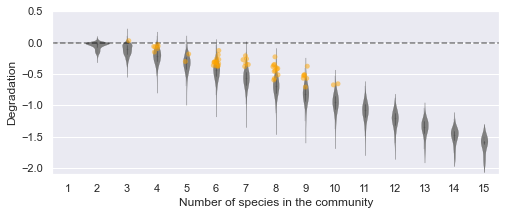

In [10]:
#%%PLOT
plt.rcParams['svg.fonttype'] = "none"
fig = plt.figure(figsize=(8,3)) 

sns.set(style="ticks")
sns.set_style("darkgrid")
ax = fig.add_subplot(1,1,1)

# make boxplot
plt.axhline(y=0, color='black', linestyle='--', alpha = 0.5)
    
#bp= sns.boxplot(x=x_, y=y_, data=df_all_all, palette="colorblind", hue='seed')
# make grouped stripplot
#bp= sns.stripplot(y="syn_deg", x="len_com", data=df_all_all, jitter=True,dodge=True, marker='o', alpha=0.5, palette="colorblind")
bp= sns.violinplot(y="syn_deg", x="len_com", data=df_all_all, jitter=True,dodge=True, 
                   marker='o', alpha=0.5, color="grey", linewidth=0.2)
bp= sns.stripplot(y="syn_deg", x="len_com", data=df_comms, jitter=True,dodge=True, 
                  marker='o', alpha=0.5, color = "orange", size=5)
    
# get legend information from the plot object
handles, labels = bp.get_legend_handles_labels()
# specify just one legend
# l = plt.legend(handles[0:5], labels[0:5], title="Sp. set")
# t = plt.title("Difference between co-culture and the sum of monocultures")
plt.xlabel("Number of species in the community")
plt.ylabel("Degradation")
plt.ylim(-2.1,0.5)

plt.savefig(path_save + "violinplot_syn_deg_onlyDS.pdf")
plt.savefig(path_save + "violinplot_syn_deg_onlyDS.svg")

In [11]:
#### P-values of Kruskal-Wallis tests of whether median is different
##   in selected vs in all comms
lenvec = np.unique(df_comms.loc[df_comms.syn_deg!=-3,'len_com'])
Nlens = len(lenvec)
pvals = np.zeros(Nlens)
for i,l in enumerate(lenvec):
    data_all_len   = df_all_all.loc[df_all_all.len_com==l,'syn_deg'].values
    data_comms_len = df_comms.loc[df_comms.len_com==l,'syn_deg'].values
    data_comms_len = data_comms_len[data_comms_len!=-3]
    if len(data_comms_len)>1:
        st_degr, p_degr = scipy.stats.kruskal(data_all_len, data_comms_len)
        pvals[i] = p_degr
    
dfcomms_nonzero = df_comms.loc[df_comms.syn_deg!=-3,'syn_deg'].values
st_degr_total, p_degr_total = scipy.stats.kruskal(df_all_all.syn_deg, dfcomms_nonzero)
print(p_degr_total)
print(pvals)

6.791462238084434e-14
[0.00000000e+00 1.97658287e-03 3.18849161e-01 6.80730809e-05
 1.21936804e-04 2.50396883e-07 4.44180225e-05 1.92355944e-02]


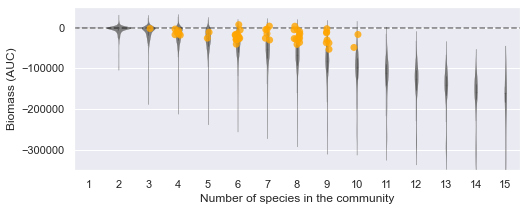

In [12]:
fig = plt.figure(figsize=(8,3)) 
sns.set(style="ticks")
sns.set_style("darkgrid")
ax = fig.add_subplot(1,1,1)
#make boxplot
plt.axhline(y=0, color='black', linestyle='--', alpha = 0.5)
#bp= sns.boxplot(x=x_, y=y_, data=df_all_all, palette="colorblind", hue='seed')
# make grouped stripplot
bp= sns.violinplot(y="syn_auc", x="len_com", data=df_all_all, jitter=True,dodge=True, 
                   marker='o', alpha=0.5, color="grey",linewidth=0.2)
bp= sns.stripplot(y="syn_auc", x="len_com", data=df_comms, 
                  jitter=True,dodge=True, marker='o', alpha=0.8, color = "orange", size=7)
    
# get legend information from the plot object
handles, labels = bp.get_legend_handles_labels()
# specify just one legend
# l = plt.legend(handles[0:5], labels[0:5], title="Sp. set")
# t = plt.title("Difference between co-culture and the sum of monocultures")
plt.xlabel("Number of species in the community")
plt.ylabel("Biomass (AUC)")
plt.ylim(-350000,50000)

plt.savefig(path_save + "violinplot_syn_auc_onlyDS.pdf")
plt.savefig(path_save + "violinplot_syn_auc_onlyDS.svg")

In [13]:
#print(df_all_all.head())
#print(df_comms.head())

lenvec = np.unique(df_comms.loc[df_comms.syn_deg!=-3,'len_com'])
Nlens = len(lenvec)
pvals_auc = np.zeros(Nlens)
for i,l in enumerate(lenvec):
    data_all_len   = df_all_all.loc[df_all_all.len_com==l,'syn_auc'].values
    data_comms_len = df_comms.loc[df_comms.len_com==l,'syn_auc'].values
    data_comms_len = data_comms_len[data_comms_len!=-3]
    if len(data_comms_len)>1:
        st_degr, p_degr = scipy.stats.kruskal(data_all_len, data_comms_len)
        pvals_auc[i] = p_degr
    
dfcomms_nonzero = df_comms.loc[df_comms.syn_auc!=-400000,'syn_auc'].values
st_degr_total, p_degr_total = scipy.stats.kruskal(df_all_all.syn_auc, dfcomms_nonzero)
print(p_degr_total)
print(pvals)

3.1827554971329314e-10
[0.00000000e+00 1.97658287e-03 3.18849161e-01 6.80730809e-05
 1.21936804e-04 2.50396883e-07 4.44180225e-05 1.92355944e-02]
